In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

llm=ChatGroq(model="openai/gpt-oss-120b")

result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'reasoning_content': 'The user says "Hello". The system says we must comply with policies. There\'s no disallowed content. We just respond politely.'}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 72, 'total_tokens': 117, 'completion_time': 0.096663604, 'completion_tokens_details': {'reasoning_tokens': 27}, 'prompt_time': 0.004095911, 'prompt_tokens_details': None, 'queue_time': 0.051105539, 'total_time': 0.100759515}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e10890e4b9', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b7f16-013b-74d1-8c9f-95e36a93e322-0', usage_metadata={'input_tokens': 72, 'output_tokens': 45, 'total_tokens': 117, 'output_token_details': {'reasoning': 27}})

In [3]:
from typing import Annotated,List
import operator
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

In [4]:
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief Overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Sections of the report"
    )

# Augment the LLM with schema for structured output
planner=llm.with_structured_output(Sections)

### Creating workers Dynamically in LangGraph

In [6]:
from langgraph.types import Send

# Graph state
class State(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections:Annotated[
        list,operator.add
    ]
    final_report: str

class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list,operator.add]

In [ ]:
## Nodes
def orchestrator(state:State):
    """Orchestrator that generates a plan for the report"""
    
    # generate queries
    report_sections=planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report"),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state:WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section=llm.invoke(
        SystemMessage(
            content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown for formatting"
        ),
        HumanMessage(
            content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
        ),
    )

    ## Write the updated section to completed sections
    return {"completed_sections": [section.content]}

## Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state:State):
    """Assign a worker to each section in the plan"""

    ## Kick off section writing in parallel via Send() API
    return [Send("llm_call",{"section":s})for s in state["sections"]]

def synthesizer(state:State):
    """Synthesize full report from sections"""

    ## List of completed sections
    completed_sections=state["completed_sections"]

    ## Format completed section to str to use as context for final sections
    completed_report_sections="\n\n-----\n\n".join(completed_sections)

    return{"final_report": completed_report_sections}

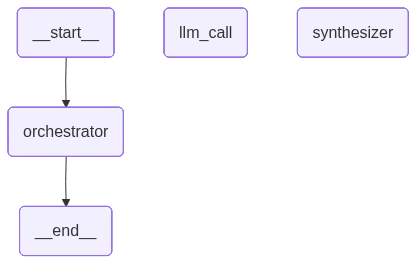

In [10]:
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display

orchestrator_worker_builder=StateGraph(State)

## Add the nodes
orchestrator_worker_builder.add_node("orchestrator",orchestrator)
orchestrator_worker_builder.add_node("llm_call",llm_call)
orchestrator_worker_builder.add_node("synthesizer",synthesizer)

## Add edgees to connect nodes
orchestrator_worker_builder.add_edge(START,"orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator",assign_workers,{"llm_call"}
)
orchestrator_worker_builder.add_edge("llm_call","synthesizer")
orchestrator_worker_builder.add_edge("synthesizer",END)

## Compile the workflow
orchestrator_worker=orchestrator_worker_builder.compile()

## Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [11]:
## Invoke
state=orchestrator_worker.invoke({"topic":"Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])

Report Sections: sections=[Section(name='Executive Summary', description='A concise overview of the report, highlighting the purpose, key findings, and recommendations regarding Agentic AI-powered Retrieval-Augmented Generation (RAG) systems.'), Section(name='1. Introduction', description='Sets the context for the report, defines Agentic AI and RAG, explains why their convergence is significant, and outlines the scope and objectives of the document.'), Section(name='2. Foundations', description='Covers the core concepts:\n- Agentic AI: autonomous agents, goal‑oriented behavior, planning, and execution.\n- Retrieval‑Augmented Generation: retrieval mechanisms, knowledge bases, and how they enhance large language models.\n- Comparative landscape of traditional LLMs vs. agentic RAG systems.'), Section(name='3. Architectural Blueprint of Agentic AI RAGs', description='Describes the end‑to‑end architecture, including:\n- Agent core (planner, executor, memory).\n- Retrieval subsystem (vector 

AttributeError: 'HumanMessage' object has no attribute 'items'